## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('universal_tagset')
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
len(nltk_data)

3914

In [221]:
# Let's see how the data in represented
nltk_data[100:125]

[[('Alan', 'NOUN'),
  ('Spoon', 'NOUN'),
  (',', '.'),
  ('recently', 'ADV'),
  ('named', 'VERB'),
  ('*', 'X'),
  ('Newsweek', 'NOUN'),
  ('president', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Newsweek', 'NOUN'),
  ("'s", 'PRT'),
  ('ad', 'NOUN'),
  ('rates', 'NOUN'),
  ('would', 'VERB'),
  ('increase', 'VERB'),
  ('5', 'NUM'),
  ('%', 'NOUN'),
  ('in', 'ADP'),
  ('January', 'NOUN'),
  ('.', '.')],
 [('A', 'DET'),
  ('full', 'ADJ'),
  (',', '.'),
  ('four-color', 'ADJ'),
  ('page', 'NOUN'),
  ('in', 'ADP'),
  ('Newsweek', 'NOUN'),
  ('will', 'VERB'),
  ('cost', 'VERB'),
  ('$', '.'),
  ('100,980', 'NUM'),
  ('*U*', 'X'),
  ('.', '.')],
 [('In', 'ADP'),
  ('mid-October', 'NOUN'),
  (',', '.'),
  ('Time', 'NOUN'),
  ('magazine', 'NOUN'),
  ('lowered', 'VERB'),
  ('its', 'PRON'),
  ('guaranteed', 'VERB'),
  ('circulation', 'NOUN'),
  ('rate', 'NOUN'),
  ('base', 'NOUN'),
  ('for', 'ADP'),
  ('1990', 'NUM'),
  ('while', 'ADP'),
  ('*-1', 'X'),
  ('not', 'ADV'),
  ('inc

The data is represented in terms of sentences in list with the word and it's tag zipped in a tuple.

There are 3914 tagged sentences in the universal dataset. Let's verify if the number of unique tags present are 12 coarse tags. 

In [4]:
# Tokenizing the sentences into words
tagged_words = [tup for sent in nltk_data for tup in sent]
tagged_words[0:20]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.'),
 ('Mr.', 'NOUN'),
 ('Vinken', 'NOUN')]

In [6]:
tags = [pair[1] for pair in tagged_words]
tags = list(set(tags))
len(tags)

12

In [7]:
# The list of all the unique tags present in the main dataset
pprint.pprint(tags)

['PRON',
 '.',
 'PRT',
 'VERB',
 'DET',
 'ADJ',
 'X',
 'ADV',
 'NUM',
 'CONJ',
 'ADP',
 'NOUN']


In [8]:
# Total number of words in the dataset
words = [pair[0] for pair in tagged_words]
len(words)

100676

In [9]:
# Total number of unique words in the dataset
unique_words = list(set(words))
len(unique_words)

12408

In [10]:
# Splitting the data into training set and validation set at a ratio of 95:5
train_tagged, val_tagged = train_test_split(tagged_words, test_size = 0.05, random_state = 102)
len(val_tagged)

5034

In [196]:
train_tagged[0:5]

[('removed', 'VERB'),
 ('its', 'PRON'),
 ('in', 'ADP'),
 ('its', 'PRON'),
 ('sale', 'NOUN')]

In [12]:
# Number of word-tag pairs in the training dataset
len(train_tagged)

95642

### Build the vanilla Viterbi based POS tagger

To build the vanilla viterbi algorithm, we need functions which could calculate the values of emission probabilities of words, transition probabilities of tags and then the viterbi heurtistic. Let's start by building the emission and transistion probability fucntions. 

In [330]:
# Building the vanilla viterbi by building the emission and transmission probability functions
# Emission probabiliy function calculates the probability of the word being emitted by the given tag state


# Calculated the count of a given word, count of the word with the given tag and 
#count of the total number of tag occurences from the training bag

def word_given_tag(word, tag, train_bag = train_tagged):
    
    tag_list = [tup for tup in train_bag if tup[1] == tag]
    count_tag = len(tag_list)
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag_list = len(word_given_tag_list)
    
    word_count = 0
    for pair in train_bag:
        if pair[0] == word:
            word_count += 1
    
    return (count_w_given_tag_list, count_tag, word_count)
    
# Calculates the Emission Probability from the word_given_tag function
    
def emission_prob(word, tag, train_bag = train_tagged): 
    
    return round((word_given_tag(word, tag) [0] / word_given_tag(word, tag)[1]), 5)


# Transition probability calculation function where it calculates the probability of tag_2 following tag_1
# for the given 2 tags 

def transition_prob(tag_2, tag_1, train_bag = train_tagged):
    
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==tag_1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index] == tag_1 and tags[index+1] == tag_2:
            count_t2_t1 += 1
            
    return (round(float(count_t2_t1/count_t1), 4))



In [331]:
# Let's test if the transition and emission probability calculations are working seamlessly 

# strong
print("\n", "strong")
print(word_given_tag('strong', 'ADJ'))
print(emission_prob('strong', 'ADJ'))
print(emission_prob('strong', 'VERB'))
print(emission_prob('strong', 'NOUN'), "\n")

# android
print("\n", "android")
print(word_given_tag('android', 'ADJ'))
print(emission_prob('android', 'ADJ'))
print(emission_prob('android', 'VERB'))
print(emission_prob('android', 'NOUN'), "\n")

# long
print("\n", "long")
print(word_given_tag('long', 'ADJ'))
print(emission_prob('long', 'ADJ'))
print(emission_prob('long', 'VERB'))
print(emission_prob('long', 'NOUN'), "\n")

# frog
print("\n", "frog")
print(word_given_tag('frog', 'NOUN'))
print(emission_prob('frog', 'ADJ'))
print(emission_prob('frog', 'VERB'))
print(emission_prob('frog', 'NOUN'), "\n")

# could
print("\n", "could")
print(emission_prob('could', 'VERB'))
print(emission_prob('could', 'PRON'))
print(emission_prob('could', 'ADP'), "\n")

# Interviews
print("Interviews")
print(emission_prob('Interviews', 'NOUN'))
print(word_given_tag('Interviews', 'NOUN'))
print(word_given_tag('interviews', 'NOUN'))
print(emission_prob('interviews', 'NOUN'), "\n")


# examples
print(transition_prob(tag_2='NOUN', tag_1='VERB'))
print(transition_prob('PRON', 'NOUN'))
print(transition_prob('PRON', 'ADJ'))
print(transition_prob('CONJ', 'ADV'))
print(transition_prob('.', 'NOUN'))
print(transition_prob('.', 'PRON'))


 strong
(24, 6091, 24)
0.00394
0.0
0.0 


 android
(0, 6091, 0)
0.0
0.0
0.0 


 long
(15, 6091, 26)
0.00246
0.0
0.0 


 frog
(0, 27464, 0)
0.0
0.0
0.0 


 could
0.00871
0.0
0.0 

Interviews
4e-05
(1, 27464, 1)
(0, 27464, 0)
0.0 

0.2828
0.0272
0.0271
0.0223
0.116
0.1218


In [332]:
# let's make a matrix of the transition probabilities of the POS tags of dimension t x t to make it easier to retrieve
# transition probability calculations

tags_matrix = np.zeros((len(tags), len(tags)), dtype = 'float32')

for i, t1 in enumerate(tags): 
    for j, t2 in enumerate(tags): 
        tags_matrix[i, j] = transition_prob(t2, t1)
tags_matrix

array([[0.0219, 0.1218, 0.038 , 0.1391, 0.0799, 0.0584, 0.0634, 0.0265,
        0.0384, 0.025 , 0.0964, 0.2912],
       [0.0257, 0.1203, 0.0307, 0.139 , 0.0907, 0.0601, 0.0619, 0.0298,
        0.0325, 0.0216, 0.0962, 0.2916],
       [0.0268, 0.1115, 0.0347, 0.1364, 0.0909, 0.0615, 0.0661, 0.0275,
        0.0379, 0.0239, 0.0906, 0.2923],
       [0.0276, 0.1176, 0.0335, 0.134 , 0.0851, 0.0619, 0.0633, 0.0313,
        0.0384, 0.0233, 0.1011, 0.2828],
       [0.0305, 0.1143, 0.0288, 0.1318, 0.0859, 0.0731, 0.0675, 0.0313,
        0.0342, 0.0197, 0.0987, 0.2841],
       [0.0271, 0.1215, 0.0315, 0.1338, 0.0859, 0.0624, 0.0703, 0.0351,
        0.0346, 0.0217, 0.102 , 0.274 ],
       [0.0288, 0.1147, 0.0325, 0.1311, 0.0853, 0.0597, 0.0655, 0.031 ,
        0.0344, 0.024 , 0.098 , 0.2951],
       [0.0269, 0.1093, 0.0332, 0.1322, 0.0817, 0.0618, 0.0714, 0.0335,
        0.0316, 0.0223, 0.0953, 0.3009],
       [0.0253, 0.1138, 0.0316, 0.1302, 0.0798, 0.0608, 0.0733, 0.0301,
        0.0369, 0.0209, 

In [17]:
tags_df = pd.DataFrame(tags_matrix, columns = tags, index= tags)
tags_df

,PRON,.,PRT,VERB,DET,ADJ,X,ADV,NUM,CONJ,ADP,NOUN
PRON,0.0219,0.1218,0.0380,0.1391,0.0799,0.0584,0.0634,0.0265,0.0384,0.0250,0.0964,0.2912
.,0.0257,0.1203,0.0307,0.1390,0.0907,0.0601,0.0619,0.0298,0.0325,0.0216,0.0962,0.2916
PRT,0.0268,0.1115,0.0347,0.1364,0.0909,0.0615,0.0661,0.0275,0.0379,0.0239,0.0906,0.2923
VERB,0.0276,0.1176,0.0335,0.1340,0.0851,0.0619,0.0633,0.0313,0.0384,0.0233,0.1011,0.2828
DET,0.0305,0.1143,0.0288,0.1318,0.0859,0.0731,0.0675,0.0313,0.0342,0.0197,0.0987,0.2841
ADJ,0.0271,0.1215,0.0315,0.1338,0.0859,0.0624,0.0703,0.0351,0.0346,0.0217,0.1020,0.2740
X,0.0288,0.1147,0.0325,0.1311,0.0853,0.0597,0.0655,0.0310,0.0344,0.0240,0.0980,0.2951
ADV,0.0269,0.1093,0.0332,0.1322,0.0817,0.0618,0.0714,0.0335,0.0316,0.0223,0.0953,0.3009
NUM,0.0253,0.1138,0.0316,0.1302,0.0798,0.0608,0.0733,0.0301,0.0369,0.0209,0.0995,0.2979
CONJ,0.0253,0.1081,0.0299,0.1423,0.0870,0.0721,0.0664,0.0346,0.0440,0.0220,0.0912,0.2770


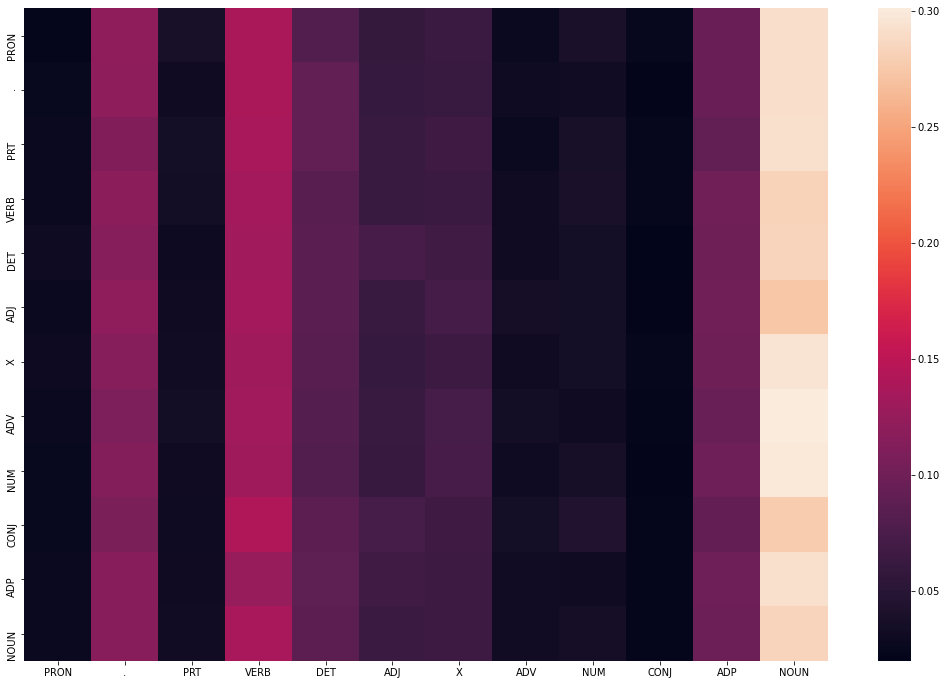

In [18]:
# Plotting a heatmap of the above calculated transition probabilities
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

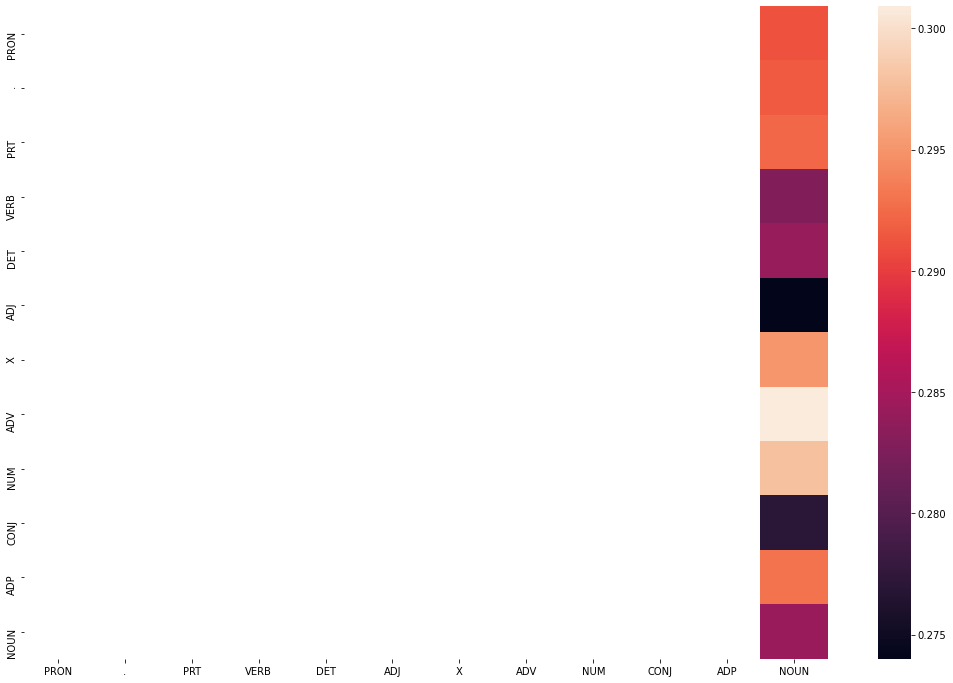

In [19]:
# frequent tags are obtained by filtering the transsition probability values above 0.25
# filter the df to get P(t2, t1) > 0.3
tags_frequent = tags_df[tags_df > 0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [333]:
# Vanilla Viterbi Algorithm - Initial Implementation 

def Viterbi(words, train_bag = train_tagged):
    state = []
    tags = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialising a list of probability values column for a given observation
        p = [] 
        for tag in tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_prob(words[key], tag)
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        # getting the state which has the maximum probability
        state_max = tags[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Testing the performance of Vanilla Vierbi

In [368]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 100 words
rndom = [random.randint(0,len(val_tagged)) for x in range(100)]

# list of tagged words
test_run = [val_tagged[i] for i in rndom]

# list of untagged words
test_tagged_words = [tup[0] for tup in test_run]
test_run

[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'NOUN'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'NOUN'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB')

In [369]:
# Randomley generated words to test the vanilla viterbi algorithm
test_tagged_words

[',',
 'move',
 ',',
 '*U*',
 'Act',
 'assault',
 '.',
 'own',
 '.',
 '0',
 ',',
 'buy',
 'Landis',
 '$',
 'on',
 'of',
 'Separately',
 "''",
 'California',
 'Papua-New',
 'stock-index',
 'Corp.',
 'one',
 'The',
 '*T*-1',
 ',',
 'there',
 'says',
 'the',
 'worked',
 'dozen',
 'injury',
 'scholar',
 'at',
 'Unicorp',
 'fell',
 'ton',
 ',',
 'few',
 'SDI',
 'good',
 'them',
 'to',
 'its',
 'ratings',
 'pathlogy',
 'Oil',
 "''",
 '0',
 'previous',
 'Jerry',
 ',',
 "''",
 '14',
 'Russell',
 'coming',
 'in',
 'cars',
 'competes',
 'eye',
 '*PPA*-2',
 'years',
 'hard-hitting',
 'investigation',
 '*-2',
 '0',
 'choosing',
 'after',
 'State',
 'courts',
 'incurred',
 ',',
 '.',
 'and',
 'In',
 'belts',
 'Southeast',
 'answers',
 'Last',
 'barometer',
 '*ICH*-1',
 'Xerox',
 'core',
 'plans',
 'Second',
 'September',
 'of',
 '*',
 'act',
 '*-1',
 'them',
 'rose',
 'acquired',
 'the',
 'the',
 'scale',
 'base',
 'punishable',
 'assault',
 'Bush']

In [370]:
# Timing the tagging process 
start = time.time()
val_tagged_seq = Viterbi(test_tagged_words)
end = time.time()

print('time taken: {0:0.2f} seconds'.format(end - start))
val_tagged_seq

time taken: 97.04 seconds


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'PRON'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'PRON'),
 ('scholar', 'PRON'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'PRON'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'PRON'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),

In [371]:
# Creating a list of the correctly tagged words to measure accuracy

correctly_tagged = [i for i, j in zip(val_tagged_seq, test_run) if i == j]
len(correctly_tagged)

89

In [372]:
len(val_tagged_seq)

100

In [373]:
# Accuracy measure of the Vanilla Viterbi Algorithm 
accuracy = len(correctly_tagged)/len(val_tagged_seq)
accuracy

0.89

#### Vanilla Viterbi accuracy - 89%

Based on testing the vanilla Viterbi algorithm with different sets of random data, it is observed to give an accuracy of anywhere between 84% to 90%, based on the chunk the size of the random data and selected from the validation set(set that hasn't been used to train the HMM). 

### Solve the problem of unknown words

To solve the problem of incorrect tagging of unknown words, let's load the test sample file and extract the unknown words
from that to see how the Vanilla Viterbi algorithm is performing against that, initially. 

In [48]:
# Loading and teading the test file as a python object

test_doc = open("Test_sentences.txt", "r").read()
print(test_doc)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






In [49]:
# Preprocessing the test text document
test_doc = test_doc.lower()
test_doc

"android is a mobile operating system developed by google.\nandroid has been the best-selling os worldwide on smartphones since 2011 and on tablets since 2013.\ngoogle and twitter made a deal in 2015 that gave google access to twitter's firehose.\ntwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nbefore entering politics, donald trump was a domineering businessman and a television personality.\nthe 2018 fifa world cup is the 21st fifa world cup, an international football tournament contested once every four years.\nthis is the first world cup to be held in eastern europe and the 11th time that it has been held in europe.\nshow me the cheapest round trips from dallas to atlanta\ni would like to see flights from denver to philadelphia.\nshow me the price of the flights leaving atlanta at about 3 in the afternoon and arriving in san francisco.\nnasa invited social media users to experience the launch of icesat-2 satell

In [50]:
# Tokenizing the document into different sentences
test_sent = sent_tokenize(test_doc)
test_sent

['android is a mobile operating system developed by google.',
 "android has been the best-selling os worldwide on smartphones since 2011 and on tablets since 2013.\ngoogle and twitter made a deal in 2015 that gave google access to twitter's firehose.",
 'twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'before entering politics, donald trump was a domineering businessman and a television personality.',
 'the 2018 fifa world cup is the 21st fifa world cup, an international football tournament contested once every four years.',
 'this is the first world cup to be held in eastern europe and the 11th time that it has been held in europe.',
 'show me the cheapest round trips from dallas to atlanta\ni would like to see flights from denver to philadelphia.',
 'show me the price of the flights leaving atlanta at about 3 in the afternoon and arriving in san francisco.',
 'nasa invited social media users to experience the 

In [51]:
# Tokenizing the document into different words
test_set = [word_tokenize(sent) for sent in test_sent]
test_set

[['android',
  'is',
  'a',
  'mobile',
  'operating',
  'system',
  'developed',
  'by',
  'google',
  '.'],
 ['android',
  'has',
  'been',
  'the',
  'best-selling',
  'os',
  'worldwide',
  'on',
  'smartphones',
  'since',
  '2011',
  'and',
  'on',
  'tablets',
  'since',
  '2013.',
  'google',
  'and',
  'twitter',
  'made',
  'a',
  'deal',
  'in',
  '2015',
  'that',
  'gave',
  'google',
  'access',
  'to',
  'twitter',
  "'s",
  'firehose',
  '.'],
 ['twitter',
  'is',
  'an',
  'online',
  'news',
  'and',
  'social',
  'networking',
  'service',
  'on',
  'which',
  'users',
  'post',
  'and',
  'interact',
  'with',
  'messages',
  'known',
  'as',
  'tweets',
  '.'],
 ['before',
  'entering',
  'politics',
  ',',
  'donald',
  'trump',
  'was',
  'a',
  'domineering',
  'businessman',
  'and',
  'a',
  'television',
  'personality',
  '.'],
 ['the',
  '2018',
  'fifa',
  'world',
  'cup',
  'is',
  'the',
  '21st',
  'fifa',
  'world',
  'cup',
  ',',
  'an',
  'internat

In [52]:
# Collecting all the words from all the sentences 
test_set_tokens = [word for sent in test_set for word in sent]
test_set_tokens

['android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'google',
 '.',
 'android',
 'has',
 'been',
 'the',
 'best-selling',
 'os',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013.',
 'google',
 'and',
 'twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'google',
 'access',
 'to',
 'twitter',
 "'s",
 'firehose',
 '.',
 'twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'before',
 'entering',
 'politics',
 ',',
 'donald',
 'trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'the',
 '2018',
 'fifa',
 'world',
 'cup',
 'is',
 'the',
 '21st',
 'fifa',
 'world',
 'cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.',
 't

In [31]:
# Identifying the list of unknown words from the test dataset 

train_tokens = [word for (word, pos) in train_tagged]
train_tokens[:80]

['removed',
 'its',
 'in',
 'its',
 'sale',
 ';',
 'big',
 'the',
 'to',
 'of',
 'be',
 'Norwegian',
 'are',
 'Sixth',
 'Los',
 'program',
 'another',
 'Savings',
 'slowdown',
 'But',
 '*-1',
 'concept',
 'MacDonald',
 'note',
 ',',
 'IRS',
 'year',
 'be',
 'strong',
 ',',
 'a',
 'the',
 ',',
 'of',
 'Dallara',
 "'s",
 'Harpo',
 '*',
 '*T*-89',
 'to',
 'with',
 'as',
 'In',
 'a',
 'than',
 'measures',
 'one',
 'initial',
 'Hawaii',
 'the',
 'Mrs.',
 "''",
 'light',
 'at',
 'wines',
 'its',
 'maturity',
 'lawyers',
 '.',
 'budget',
 'Jennison',
 '*',
 'period',
 'said',
 'of',
 'new',
 'preserving',
 'citing',
 'kilobytes',
 'for',
 'cleaner-burning',
 ',',
 '15',
 'Elco',
 'and',
 'in',
 'with',
 'have',
 ',',
 ',']

In [32]:
len(train_tokens)
test_set_tokens[0:20]

['android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'google',
 '.',
 'android',
 'has',
 'been',
 'the',
 'best-selling',
 'os',
 'worldwide',
 'on',
 'smartphones',
 'since']

In [33]:
# Extracting the unknown tokens from the sample test dataset for later use
unknown_tokens = [i for i in test_set_tokens if i not in train_tokens]
unknown_tokens

['android',
 'google',
 'android',
 'os',
 'worldwide',
 'smartphones',
 '2011',
 '2013.',
 'google',
 'twitter',
 '2015',
 'google',
 'twitter',
 'firehose',
 'twitter',
 'online',
 'interact',
 'messages',
 'tweets',
 'donald',
 'trump',
 'domineering',
 'personality',
 '2018',
 'fifa',
 'cup',
 '21st',
 'fifa',
 'cup',
 'tournament',
 'contested',
 'cup',
 'eastern',
 'europe',
 'europe',
 'trips',
 'dallas',
 'atlanta',
 'i',
 'denver',
 'philadelphia',
 'atlanta',
 'arriving',
 'san',
 'francisco',
 'nasa',
 'invited',
 'icesat-2',
 'satellite']

In [34]:
# Number of unknown tokens from the sample test dataset
len(unknown_tokens)

49

There are totally 49 unknown words in the sample test set. Let's see what Viterbi's Algorithm is 
tagging them with initially 

In [35]:
Viterbi(unknown_tokens)

[('android', 'PRON'),
 ('google', 'PRON'),
 ('android', 'PRON'),
 ('os', 'PRON'),
 ('worldwide', 'PRON'),
 ('smartphones', 'PRON'),
 ('2011', 'PRON'),
 ('2013.', 'PRON'),
 ('google', 'PRON'),
 ('twitter', 'PRON'),
 ('2015', 'PRON'),
 ('google', 'PRON'),
 ('twitter', 'PRON'),
 ('firehose', 'PRON'),
 ('twitter', 'PRON'),
 ('online', 'PRON'),
 ('interact', 'PRON'),
 ('messages', 'PRON'),
 ('tweets', 'PRON'),
 ('donald', 'PRON'),
 ('trump', 'PRON'),
 ('domineering', 'PRON'),
 ('personality', 'PRON'),
 ('2018', 'PRON'),
 ('fifa', 'PRON'),
 ('cup', 'PRON'),
 ('21st', 'PRON'),
 ('fifa', 'PRON'),
 ('cup', 'PRON'),
 ('tournament', 'PRON'),
 ('contested', 'PRON'),
 ('cup', 'PRON'),
 ('eastern', 'PRON'),
 ('europe', 'PRON'),
 ('europe', 'PRON'),
 ('trips', 'PRON'),
 ('dallas', 'PRON'),
 ('atlanta', 'PRON'),
 ('i', 'PRON'),
 ('denver', 'PRON'),
 ('philadelphia', 'PRON'),
 ('atlanta', 'PRON'),
 ('arriving', 'PRON'),
 ('san', 'PRON'),
 ('francisco', 'PRON'),
 ('nasa', 'PRON'),
 ('invited', 'PRON'),


Since the HMM has not seen these words previously, it is tagging all of them with the first tag from the tags list. 

In [36]:
pprint.pprint(tags)

['PRON',
 '.',
 'PRT',
 'VERB',
 'DET',
 'ADJ',
 'X',
 'ADV',
 'NUM',
 'CONJ',
 'ADP',
 'NOUN']


Since Pronoun is the first tag, Vanilla Viterbi algorithm is tagging all the unknown words as Pronouns. 

In [37]:
# Training dataset tagged words
train_tagged[0:40]

[('removed', 'VERB'),
 ('its', 'PRON'),
 ('in', 'ADP'),
 ('its', 'PRON'),
 ('sale', 'NOUN'),
 (';', '.'),
 ('big', 'ADJ'),
 ('the', 'DET'),
 ('to', 'PRT'),
 ('of', 'ADP'),
 ('be', 'VERB'),
 ('Norwegian', 'NOUN'),
 ('are', 'VERB'),
 ('Sixth', 'NOUN'),
 ('Los', 'NOUN'),
 ('program', 'NOUN'),
 ('another', 'DET'),
 ('Savings', 'NOUN'),
 ('slowdown', 'NOUN'),
 ('But', 'CONJ'),
 ('*-1', 'X'),
 ('concept', 'NOUN'),
 ('MacDonald', 'NOUN'),
 ('note', 'NOUN'),
 (',', '.'),
 ('IRS', 'NOUN'),
 ('year', 'NOUN'),
 ('be', 'VERB'),
 ('strong', 'ADJ'),
 (',', '.'),
 ('a', 'DET'),
 ('the', 'DET'),
 (',', '.'),
 ('of', 'ADP'),
 ('Dallara', 'NOUN'),
 ("'s", 'PRT'),
 ('Harpo', 'NOUN'),
 ('*', 'X'),
 ('*T*-89', 'X'),
 ('to', 'PRT')]

In [38]:
# Performing a train test split on sentence tokenized data to feed it to the default taggers
train_sents, val_sents = train_test_split(nltk_data, test_size = 0.3)

#### N-gram POS Taggers

Let's experiment with a few off the shelf taggers

In [39]:
# Evaluating the accuracy of the unigram tagger on the validation set
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(val_sents)

0.8891522029372496

In [40]:
# Evaluating the accuracy of the bigram tagger on the validation set
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.evaluate(val_sents)

0.18554739652870494

In [41]:
# Evaluating the accuracy of the trigram tagger on the validation set
trigram_tagger = nltk.TrigramTagger(train_sents)
trigram_tagger.evaluate(val_sents)

0.09712950600801068

Since the Unigram tagger offers a much higher accuracy, let's use that in tandem with the viterbi's algorithm to make the 
tagging process better. 

In [79]:
tags = list(set([pair[1] for sent in train_sents for pair in sent]))
print(tags)

['PRON', '.', 'PRT', 'VERB', 'DET', 'ADJ', 'X', 'ADV', 'NUM', 'CONJ', 'ADP', 'NOUN']


In [374]:
# Modifying the Viterbi algorithm to be backed by the unigram tagger 

def Viterbi_mod(words, train_bag = train_tagged):

    state = []
    tags = list(set([tup[1] for tup in train_bag]))
    word_pairs = []
    unknown_words = []
    
    # Training the unigram tagger with the training set sentences
    uni_parser = nltk.UnigramTagger(train_sents)   
    
    for key, word in enumerate(words):
        p = []                              #initialising an empty list to store the probability values for a given observation

        for tag in tags:

            if len(state) == 0:
                transition_p = tags_df.loc['.', tag]        # Calculating transistion prob based on the previous tag for the word
            else:
                transition_p = tags_df.loc[state[-1], tag]

            emission_p = emission_prob(words[key], tag)      # compute emission and state probabilities
            
            state_probability = emission_p * transition_p
            p.append(state_probability)

           
        pmax = max(p)                          # getting the state which has the maximum probability
        
        if pmax >= 0.001:                      # If the incidence rate of the word is greater than one-thousanth
            
            state_max = tags[p.index(pmax)]        
            state.append(state_max)                
            word_pairs.append((word, state[-1]))   
            
        else: 
            uni_parsed = uni_parser.tag([word])
            word_pairs.extend(uni_parsed)

    

    return word_pairs


In [364]:
# Testing the modified Viterbi algorithm on a few sample sentences from the validation dataset
random.seed(42)

# choosing 100 random words
rndom = [random.randint(0,len(val_tagged)) for x in range(100)]

# list of tagged words
test_run = [val_tagged[i] for i in rndom]

# list of untagged words
test_tagged_words = [tup[0] for tup in test_run]
test_run

[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'NOUN'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'NOUN'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB')

In [365]:
start = time.time()
viterbi_2nd = Viterbi_mod(test_tagged_words)
end = time.time()

print(f"Time taken: {end - start}")
viterbi_2nd

Time taken: 102.2461907863617


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', None),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),
 

In [366]:
correctly_tagged = [i for i, j in zip(viterbi_2nd, test_run) if i == j]
len(correctly_tagged)

93

In [367]:
len(viterbi_2nd)
#/len(test_run)

100

#### Modified Viterbi's Algorithm accuracy - 93%

The modified Viterbi's algorithm, which is backed off by the Unigram Tagger, gives an accruacy of 90% for the same chunk of 
validation data tested using the vanilla viterbi algorithm. The vanilla viterbi gave an accuracy of 84.5% for the same chunk
of random data. 

In [219]:
# Vizualizing the tags
tags

['PRON',
 '.',
 'PRT',
 'VERB',
 'DET',
 'ADJ',
 'X',
 'ADV',
 'NUM',
 'CONJ',
 'ADP',
 'NOUN']

In [422]:
# Defining rules for pos tagging the unknown words

patterns = [
    (r"[A-Z][a-z].{4,}", 'NOUN'),                             # Words that start with capital letter and a length of 5 characters as noun
    (r"\w.*ing$", 'VERB'),                                    # Words that end with 'ing' as verb 
    (r"\w.*ed$", 'VERB'),                                     # Words that end with 'ed' as verb
    (r"\d.*/.?,*\d.*", 'NUM'),                                # pure digits with commas and decimal numbers of any length as numbers
    (r"([BbMmTt]illion|[Tt]housand|[Hh]undred|[Ll]akh|[Cc]rore)", "NUM"), # Number words as numbers
    (r"([Oo]ne|[Tt]wo|[Tt]hree|[Ff]our|[Ff]ive)", "NUM"),     # Number words from 1 to 5 as numbers
    (r".*tion$", 'NOUN'),                                     # Words ending with 'tion' 
    (r"[%*$.,+=]", "."),                                      # Punctuations 
    (r"0", "X"),                                              # 0 as an unknown character
    (r"(The|the|A|An|a|an)", 'DET'),                           # Determiners
    (r"(this|that|these|those)", 'DET'),                       # Determiners
    (r"(for|and|nor|but|or|yet|so)", "CONJ"),                  # Coordinating Conjunctions
    (r"(both|neither|either|whether)","CONJ"),                 # Correlative Conjunctions
    (r"(after|before|although|though|as|if|only|until|unless|whenever|whereas|wherever|whether|while)", "CONJ"), # Subordinating Conjunctions
    (r"\w.*/-\d{1,3}$", 'NOUN'),                              # Words of any length that end of a hypen and a number of  max length 3 as noun 
    (r".*", 'NOUN')                                          # Unknown words as nouns
]

In [423]:
# Regexp tagger's performance on the validation set
from nltk.tag import RegexpTagger
from nltk.tag import SequentialBackoffTagger 

re_parser = RegexpTagger(patterns)
re_parser.evaluate(val_sents)

0.5052069425901201

##### Regexp Tagger standalone accuracy - 50.5%

The Regexp tagger gives an accuracy of 50% with just a few basic rules. Let's try to pair this up with the Viterbi's 
algorithm. 

In [424]:
uni_parser = nltk.UnigramTagger(train_sents, backoff = re_parser)
uni_parser.evaluate(val_sents)

0.935347129506008

##### Unigram parser backed by the Regexp parser accuracy - 93.5%

The Unigram tagger in the nltk library offers a standalone accuracy of 89% and paired with the regexp tagger as the 
backoff tagger, the accuracy has moved up to 91%. Let's see if there's further an improvement by pairing it up with the 
Viterbi's Algorithm. 


In [425]:
# Modifying the Viterbi algorithm to be backed off by the Unigram tagger and the regexp tagger
def Viterbi_mod_re(words, train_bag = train_tagged):
    
    state = []
    tags = list(set([tup[1] for tup in train_bag]))
    word_pairs = []
    unknown_words = []
    
    # Using a Unigram tagger backed by a regexp parser with custom rules 
    uni_parser_re = nltk.UnigramTagger(train_sents, backoff = re_parser)


    for key, word in enumerate(words):
        p = []                              #initialising an empty list to store the probability values for a given observation

        for tag in tags:

            if len(state) == 0:
                transition_p = tags_df.loc['.', tag]        # Calculating transistion prob based on the previous tag for the word
            else:
                transition_p = tags_df.loc[state[-1], tag]

            emission_p = emission_prob(words[key], tag)      # compute emission and state probabilities
            
            state_probability = emission_p * transition_p
            p.append(state_probability)

           
        pmax = max(p)                          # getting the state which has the maximum probability
        
        if pmax >= 0.001:                   # If the incidence rate of the word is greater than one-thousanth
            
            state_max = tags[p.index(pmax)]        
            state.append(state_max)                
            word_pairs.append((word, state[-1]))   
            
        else: 
            uni_parsed = uni_parser_re.tag([word])
            word_pairs.extend(uni_parsed)

                

    return word_pairs


In [426]:
# Testing the modified RE Viterbi algorithm on a few sample sentences of test dataset
random.seed(42)

# choose random 100 words
rndom = [random.randint(0,len(val_tagged)) for x in range(100)]

# list of tagged words
test_run = [val_tagged[i] for i in rndom]

# list of untagged words
test_tagged_words = [tup[0] for tup in test_run]
test_run

[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'NOUN'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'NOUN'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB')

In [427]:
start = time.time()
viterbi_3rd = Viterbi_mod_re(words = test_tagged_words)
end = time.time()

print(f"Time taken: {end - start}")
viterbi_3rd

Time taken: 47.0446240901947


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'NOUN'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),

In [428]:
correctly_tagged = [i for i, j in zip(viterbi_3rd, test_run) if i == j]
len(correctly_tagged)

95

In [429]:
len(viterbi_3rd)
#/len(test_run)

100

In [430]:
len(correctly_tagged)/len(test_run)

0.95

#### Modified Regexp Viterbi's Algorithm accuracy - 95%

The modified Viterbi's algorithm, which is backed off by the Unigram Tagger and regexp parser, gives an accruacy of 94% for the same chunk of validation data tested using the vanilla viterbi algorithm. The vanilla viterbi gave an accuracy of 84.5% for the same chunk of random data and the first modification using the unigram tagger in tandem with the viterbi's algorithm gave an accuracy of 90%. 

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [382]:
# Initializing a random subset of data from the validation set to compare accuracies


random.seed(98)

# choose random 100 words
rndom = [random.randint(0,len(val_tagged)) for x in range(100)]

# list of tagged words
test_run = [val_tagged[i] for i in rndom]

# list of untagged words
test_tagged_words = [tup[0] for tup in test_run]
test_run

[('of', 'ADP'),
 ('WAFA', 'NOUN'),
 ('early', 'ADV'),
 ('for', 'ADP'),
 ('after', 'ADP'),
 ('do', 'VERB'),
 ('which', 'DET'),
 ('Mr.', 'NOUN'),
 ('millions', 'NOUN'),
 ('Union', 'NOUN'),
 ('to', 'PRT'),
 ('spokesman', 'NOUN'),
 ('.', '.'),
 ('solicitous', 'ADJ'),
 ('had', 'VERB'),
 ('of', 'ADP'),
 ('are', 'VERB'),
 ('of', 'ADP'),
 (',', '.'),
 ('``', '.'),
 ('replaced', 'VERB'),
 ('of', 'ADP'),
 (',', '.'),
 ('Given', 'VERB'),
 ('Kenneth', 'NOUN'),
 ('of', 'ADP'),
 ('into', 'ADP'),
 ('ballot', 'NOUN'),
 ('so', 'ADV'),
 (',', '.'),
 (',', '.'),
 ('*-1', 'X'),
 ('from', 'ADP'),
 ('But', 'CONJ'),
 ('programs', 'NOUN'),
 ('which', 'DET'),
 ('only', 'ADV'),
 ('where', 'ADV'),
 ('Either', 'CONJ'),
 ('he', 'PRON'),
 ('memo', 'NOUN'),
 ('labor-management', 'NOUN'),
 ('*', 'X'),
 ('employers', 'NOUN'),
 ('and', 'CONJ'),
 ('forcing', 'ADJ'),
 ('by', 'ADP'),
 ('there', 'DET'),
 ('marketers', 'NOUN'),
 ('little', 'ADJ'),
 ('a', 'DET'),
 ('Hahn', 'NOUN'),
 ('of', 'ADP'),
 ('ill', 'ADJ'),
 ('scrutin

In [417]:
start = time.time()
vanilla_viterbi = Viterbi(words = test_tagged_words)
end = time.time()

print(f"Time taken: {end - start}")
vanilla_viterbi

Time taken: 48.576603412628174


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'PRON'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'PRON'),
 ('scholar', 'PRON'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'PRON'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'PRON'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),

In [418]:
start = time.time()
viterbi_mod = Viterbi_mod(words = test_tagged_words)
end = time.time()

print(f"Time taken: {end - start}")
viterbi_mod

Time taken: 48.68871474266052


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', None),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),
 

In [432]:
start = time.time()
viterbi_re = Viterbi_mod_re(words = test_tagged_words)
end = time.time()

print(f"Time taken: {end - start}")
viterbi_re

Time taken: 48.676042795181274


[(',', '.'),
 ('move', 'NOUN'),
 (',', '.'),
 ('*U*', 'X'),
 ('Act', 'NOUN'),
 ('assault', 'NOUN'),
 ('.', '.'),
 ('own', 'ADJ'),
 ('.', '.'),
 ('0', 'X'),
 (',', '.'),
 ('buy', 'VERB'),
 ('Landis', 'NOUN'),
 ('$', '.'),
 ('on', 'ADP'),
 ('of', 'ADP'),
 ('Separately', 'ADV'),
 ("''", '.'),
 ('California', 'NOUN'),
 ('Papua-New', 'NOUN'),
 ('stock-index', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('one', 'NUM'),
 ('The', 'DET'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('there', 'DET'),
 ('says', 'VERB'),
 ('the', 'DET'),
 ('worked', 'VERB'),
 ('dozen', 'NOUN'),
 ('injury', 'NOUN'),
 ('scholar', 'NOUN'),
 ('at', 'ADP'),
 ('Unicorp', 'NOUN'),
 ('fell', 'VERB'),
 ('ton', 'NOUN'),
 (',', '.'),
 ('few', 'ADJ'),
 ('SDI', 'NOUN'),
 ('good', 'ADJ'),
 ('them', 'PRON'),
 ('to', 'PRT'),
 ('its', 'PRON'),
 ('ratings', 'NOUN'),
 ('pathlogy', 'NOUN'),
 ('Oil', 'NOUN'),
 ("''", '.'),
 ('0', 'X'),
 ('previous', 'ADJ'),
 ('Jerry', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('14', 'NUM'),
 ('Russell', 'NOUN'),
 ('coming', 'VERB'),

In [433]:
correctly_tagged_vv = [i for i, j in zip(vanilla_viterbi, test_run) if i == j]
print(f"Vanilla Viterbi accuracy: {len(correctly_tagged_vv)/100}")
correctly_tagged_vmod = [i for i, j in zip(viterbi_mod, test_run) if i == j]
print(f"Viterbi modified accuracy: {len(correctly_tagged_vmod)/100}")
correctly_tagged_re = [i for i, j in zip(viterbi_re, test_run) if i == j]
print(f"Viterbi Regexp accuracy: {len(correctly_tagged_re)/100}")

Vanilla Viterbi accuracy: 0.89
Viterbi modified accuracy: 0.93
Viterbi Regexp accuracy: 0.95


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [ ]:
To see if the taggers have increased in tagging accuracy of truly unknown words, we'll see how the three taggers perform on
the unknown words extracted from the sample test dataset. 

In [390]:
# The list of unknown tokens extracted from the sample test dataset (untagged)
# The sample test dataset was tokenized into sentences and words and the unknown tokens were extracted into a separate file

unknown_tokens

['android',
 'google',
 'android',
 'os',
 'worldwide',
 'smartphones',
 '2011',
 '2013.',
 'google',
 'twitter',
 '2015',
 'google',
 'twitter',
 'firehose',
 'twitter',
 'online',
 'interact',
 'messages',
 'tweets',
 'donald',
 'trump',
 'domineering',
 'personality',
 '2018',
 'fifa',
 'cup',
 '21st',
 'fifa',
 'cup',
 'tournament',
 'contested',
 'cup',
 'eastern',
 'europe',
 'europe',
 'trips',
 'dallas',
 'atlanta',
 'i',
 'denver',
 'philadelphia',
 'atlanta',
 'arriving',
 'san',
 'francisco',
 'nasa',
 'invited',
 'icesat-2',
 'satellite']

In [391]:
unknown_vv = Viterbi(unknown_tokens)
unknown_vv

[('android', 'PRON'),
 ('google', 'PRON'),
 ('android', 'PRON'),
 ('os', 'PRON'),
 ('worldwide', 'PRON'),
 ('smartphones', 'PRON'),
 ('2011', 'PRON'),
 ('2013.', 'PRON'),
 ('google', 'PRON'),
 ('twitter', 'PRON'),
 ('2015', 'PRON'),
 ('google', 'PRON'),
 ('twitter', 'PRON'),
 ('firehose', 'PRON'),
 ('twitter', 'PRON'),
 ('online', 'PRON'),
 ('interact', 'PRON'),
 ('messages', 'PRON'),
 ('tweets', 'PRON'),
 ('donald', 'PRON'),
 ('trump', 'PRON'),
 ('domineering', 'PRON'),
 ('personality', 'PRON'),
 ('2018', 'PRON'),
 ('fifa', 'PRON'),
 ('cup', 'PRON'),
 ('21st', 'PRON'),
 ('fifa', 'PRON'),
 ('cup', 'PRON'),
 ('tournament', 'PRON'),
 ('contested', 'PRON'),
 ('cup', 'PRON'),
 ('eastern', 'PRON'),
 ('europe', 'PRON'),
 ('europe', 'PRON'),
 ('trips', 'PRON'),
 ('dallas', 'PRON'),
 ('atlanta', 'PRON'),
 ('i', 'PRON'),
 ('denver', 'PRON'),
 ('philadelphia', 'PRON'),
 ('atlanta', 'PRON'),
 ('arriving', 'PRON'),
 ('san', 'PRON'),
 ('francisco', 'PRON'),
 ('nasa', 'PRON'),
 ('invited', 'PRON'),


Since HMM hasn't seen these words, it is tagging them with the first tag from the tags list, which is the Pronoun tag.

In [392]:
unknown_vmod = Viterbi_mod(unknown_tokens)
unknown_vmod

[('android', None),
 ('google', None),
 ('android', None),
 ('os', None),
 ('worldwide', None),
 ('smartphones', None),
 ('2011', None),
 ('2013.', None),
 ('google', None),
 ('twitter', None),
 ('2015', None),
 ('google', None),
 ('twitter', None),
 ('firehose', None),
 ('twitter', None),
 ('online', None),
 ('interact', None),
 ('messages', None),
 ('tweets', None),
 ('donald', None),
 ('trump', None),
 ('domineering', None),
 ('personality', None),
 ('2018', None),
 ('fifa', None),
 ('cup', None),
 ('21st', None),
 ('fifa', None),
 ('cup', None),
 ('tournament', None),
 ('contested', None),
 ('cup', None),
 ('eastern', None),
 ('europe', None),
 ('europe', None),
 ('trips', None),
 ('dallas', None),
 ('atlanta', None),
 ('i', None),
 ('denver', None),
 ('philadelphia', None),
 ('atlanta', None),
 ('arriving', None),
 ('san', None),
 ('francisco', None),
 ('nasa', None),
 ('invited', None),
 ('icesat-2', None),
 ('satellite', None)]

Since the Unigram tagger also hasn't seen these words, since even it was trained on the training dataset, it is tagging 
all of them with the None tag. 

In [435]:
unknown_re = Viterbi_mod_re(unknown_tokens)
unknown_re

[('android', 'DET'),
 ('google', 'NOUN'),
 ('android', 'DET'),
 ('os', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'NOUN'),
 ('2011', 'NOUN'),
 ('2013.', 'NOUN'),
 ('google', 'NOUN'),
 ('twitter', 'NOUN'),
 ('2015', 'NOUN'),
 ('google', 'NOUN'),
 ('twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'NOUN'),
 ('tweets', 'NOUN'),
 ('donald', 'NOUN'),
 ('trump', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NOUN'),
 ('fifa', 'NOUN'),
 ('cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('fifa', 'NOUN'),
 ('cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('cup', 'NOUN'),
 ('eastern', 'NOUN'),
 ('europe', 'NOUN'),
 ('europe', 'NOUN'),
 ('trips', 'NOUN'),
 ('dallas', 'NOUN'),
 ('atlanta', 'DET'),
 ('i', 'NOUN'),
 ('denver', 'NOUN'),
 ('philadelphia', 'NOUN'),
 ('atlanta', 'DET'),
 ('arriving', 'VERB'),
 ('san', 'NOUN'),
 ('francisco', 'NOUN'),
 ('nasa', 'NOUN'),
 ('invited', 'VERB'),
 ('i

In [ ]:
As we can see, most of the words are Nouns in the unknown words list and the Regexp-backed Viterbi tagger has tagged them 
more accurately than the other two taggers. 